# SARS-COV-2 Ct-Scan Dataset

## Downloading the Sars-Cov2 ct-scan Dataset from kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files

# Choose the kaggle.json file that you downloaded
files.upload()

# Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json


# !kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# downloading the dataset for a specific competition
!kaggle datasets download -d "plameneduardo/sarscov2-ctscan-dataset"

sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the data set
import zipfile

zip_ref = zipfile.ZipFile("sarscov2-ctscan-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Make 3 directories named train, test and sarscov2-ctscan-dataset
!mkdir train test sarscov2-ctscan-dataset 


mkdir: cannot create directory ‘sarscov2-ctscan-dataset’: File exists


In [ ]:
# Move the covid and non-covid data to the train directory
!mv COVID non-COVID train

# Make two more directories named COVID non-COVID
!mkdir COVID non-COVID

# Move the covid and non-covid data to the test directory
!mv COVID non-COVID test

# Move the train directory to sarscov2-ctscan-dataset
!mv train test sarscov2-ctscan-dataset


mv: cannot move 'train' to 'sarscov2-ctscan-dataset/train': Directory not empty
mv: cannot move 'test' to 'sarscov2-ctscan-dataset/test': Directory not empty


## Load the dataset 

In [ ]:
# Set the train and test directories
train_dir = "sarscov2-ctscan-dataset/train"
test_dir = "sarscov2-ctscan-dataset/test"

In [ ]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

(train_data, test_data) = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='binary',
                                                                #  color_mode='rgba',
                                                                 image_size=IMAGE_SIZE,
                                                                #  batch_size=BATCH_SIZE,
                                                                 validation_split=0.15,
                                                                 subset='both',
                                                                 seed=43)
# test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
#                                                                  label_mode='binary',
#                                                                  image_size=IMAGE_SIZE,
#                                                                  batch_size=BATCH_SIZE)

Found 2481 files belonging to 2 classes.
Using 2109 files for training.
Using 372 files for validation.


In [ ]:
# Getting the categories names i.e class names
class_names = train_data.class_names
class_names

['COVID', 'non-COVID']

## Plot some images from the train dataset

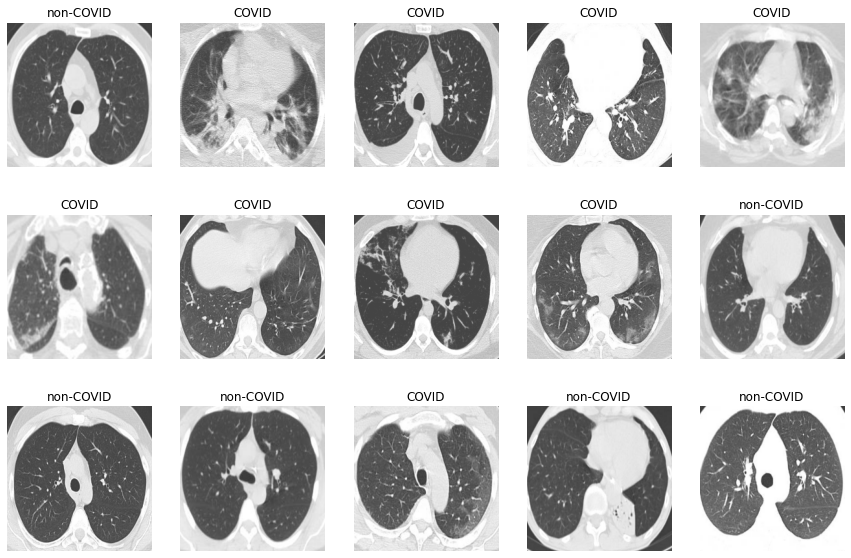

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_data.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[int(labels[i].numpy()[0])])
    plt.axis(False)

## Data Augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1/255.0) # No need in effiecientnet, needed in mobilenet
], name='data_augmentation')

In [ ]:
# Setup the model 
# Create a base model of efficientnetb7, by defult the color channel must be 3.
base_model = tf.keras.applications.vgg16.VGG16(include_top=False)

# Freeze the layers of base model
base_model.trainable = False

# Create an input layer
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,),
                              #  batch_size=BATCH_SIZE,
                               name='input_layer')

# Augment the inputs layers output
x = data_augmentation(inputs)

# Pass the inputs to the base model
x = base_model(inputs)

# Create the GlobalAveragePooling2D layers, which normalizes the values between 0 & 1.
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Creating 3 Dense layers
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dense(units=32, activation='relu')(x)

# Creating a dropout layer
x = tf.keras.layers.Dropout(rate=0.40, seed=43)(x)

# Create the output Dense layer having two units.
outputs = tf.keras.layers.Dense(units=len(train_data.class_names) -1, 
                                activation='sigmoid',
                                name='output_layer')(x)

# Now Create the model and pass the inputs and output 
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling_laye  (None, 512)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                           

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Number of layers in the base model and which layers are trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Now compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Fit the model on the train data for 10 epochs
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=40,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)))

Epoch 1/40
66/66 [==============================] - 12s 144ms/step - loss: 0.6279 - accuracy: 0.7022 - val_loss: 0.3691 - val_accuracy: 0.8125
Epoch 2/40
66/66 [==============================] - 9s 128ms/step - loss: 0.3808 - accuracy: 0.8336 - val_loss: 0.3355 - val_accuracy: 0.8438
Epoch 3/40
66/66 [==============================] - 9s 126ms/step - loss: 0.2993 - accuracy: 0.8743 - val_loss: 0.2888 - val_accuracy: 0.8750
Epoch 4/40
66/66 [==============================] - 10s 143ms/step - loss: 0.2439 - accuracy: 0.8976 - val_loss: 0.3474 - val_accuracy: 0.8438
Epoch 5/40
66/66 [==============================] - 11s 144ms/step - loss: 0.1744 - accuracy: 0.9331 - val_loss: 0.2439 - val_accuracy: 0.9062
Epoch 6/40
66/66 [==============================] - 10s 133ms/step - loss: 0.1612 - accuracy: 0.9445 - val_loss: 0.1845 - val_accuracy: 0.8750
Epoch 7/40
66/66 [==============================] - 9s 128ms/step - loss: 0.1341 - accuracy: 0.9483 - val_loss: 0.2311 - val_accuracy: 0.9375
Ep

## Evaluate the model on the complete test data i.e. 100% test data

In [ ]:
model.evaluate(test_data)

12/12 [==============================] - 2s 125ms/step - loss: 0.1312 - accuracy: 0.9651


[0.13122014701366425, 0.9650537371635437]

In [ ]:
# Predicting the results of the test data
y_preds = model.predict(test_data)
y_preds[:10]

12/12 [==============================] - 2s 137ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.2473185e-09],
       [1.0169706e-05],
       [1.1250909e-09],
       [4.5962638e-06],
       [4.7702536e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.8281929e-12]], dtype=float32)

In [ ]:
y_pred = []
for i in y_preds:
  if i > 0.50:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred[:10]

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and label
 y_labels.append(int(labels.numpy()[0])) # append the index which has the largest value (
y_labels[:10] # check what they look like (unshuffled)

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
import numpy as np
np.concatenate((np.array(y_labels).reshape(len(y_pred), 1), np.array(y_pred).reshape(len(y_pred), 1)), axis=1)

array([[1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0,

In [ ]:
new = np.array(y_labels).reshape(len(y_pred), 1) == np.array(y_pred).reshape(len(y_pred), 1)
list(new).count(False), len(list(new))

(13, 372)

In [ ]:
# Getting the classification score 
from sklearn.metrics import classification_report
classification_report = classification_report(y_labels, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       201
           1       0.95      0.97      0.96       171

    accuracy                           0.97       372
   macro avg       0.96      0.97      0.96       372
weighted avg       0.97      0.97      0.97       372



In [ ]:
# Getting the accuracy score using scikit-learn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, y_pred)
accuracy

0.9650537634408602

In [ ]:
# Getting the f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_labels, y_pred)
f1_score

0.9623188405797101

In [ ]:
# Making the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_labels, y_pred)
confusion_matrix

array([[193,   8],
       [  5, 166]])

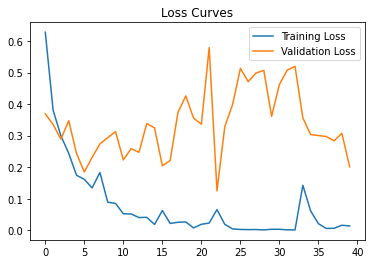

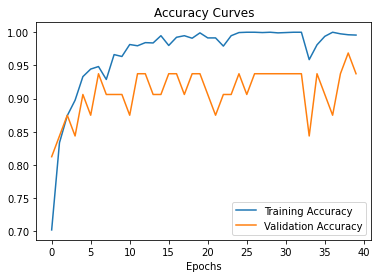

In [ ]:
# Plot the loss and accuracy curves
import matplotlib.pyplot as plt

# Getting the loss values from the history 
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot the loss curves
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

# Plot the accuracy curves
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.legend()
